## Keras Tuner

[keras_tuner](https://keras.io/keras_tuner/) supports grid search, random search and Bayesian optimization. It is suited for TensorFlow and, through Keras 3.0, for PyTorch and JAX as well.\
Here we present a random search on the MNIST dataset using a multilayer perceptron in TensorFlow.

In [1]:
import os; os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # silence tensorflow

import sys; sys.path.append("../") # add repository to path 

import warnings; warnings.filterwarnings("ignore") # suppress warnings

# import libraries for visualization
from IPython.display import display
import matplotlib.pyplot as plt

# set plotting options
%config InlineBackend.figure_format = "svg"
plt.rc("text", usetex=True)
plt.rc("font", family="cm")
plt.rc("axes", grid=False)
plt.rc("ytick", direction="out", color="gray")
plt.rcParams.update({"font.size": 12})

# import package
from par_coordinates import get_results
from par_coordinates import plot_par_coordinates

# import libraries for keras example
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras_tuner.tuners import RandomSearch

# import libraries for sklearn example
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# import libraries for optuna example
import xgboost as xgb
from sklearn.datasets import load_diabetes
import optuna; optuna.logging.set_verbosity(optuna.logging.WARNING) # silence optuna warnings

In [2]:
def build_model(hp):
    """
    Builds a multilayer perceptron according to hyperparameters specified by the random search.
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(28, 28)))
    model.add(layers.Flatten())
    # choose the number of units in the hidden layer
    hp_units = hp.Int("units", min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units, activation="relu"))
    # final dense layer for classification
    model.add(layers.Dense(10, activation="softmax"))
    # choose the learning rate for the optimizer
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    # compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [3]:
# load and preprocess the training dataset
mnist = keras.datasets.mnist
(X_train, y_train), _ = mnist.load_data()
X_train = X_train / 255.0

# instantiate the tuner and perform random search
tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=3, # cross-validation
    directory="../outputs/data/tuning", # results directory
    project_name="mnist_hyperparam_tuning")

tuner.search(X_train, y_train, epochs=5, validation_split=0.2)

Reloading Tuner from ../outputs/data/tuning/mnist_hyperparam_tuning/tuner0.json


In [4]:
results = get_results.keras_tuner(tuner, metric="val_accuracy", num_best_trials=10)
display(results.head())

,units,learning_rate,val_accuracy
0,512,0.0010,0.977139
1,224,0.0010,0.975722
2,160,0.0010,0.974278
3,96,0.0010,0.971556
4,384,0.0001,0.961833


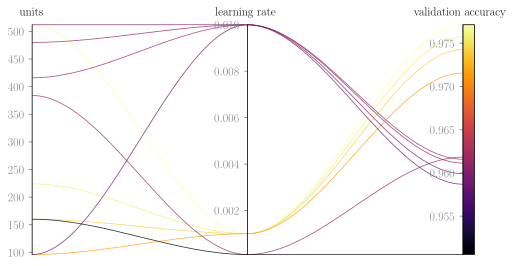

In [5]:
fig = plot_par_coordinates(results, labels=["units", "learning rate", "validation accuracy"], figsize=(8, 4), 
                           linewidth=0.8, alpha=0.8, cmap=plt.get_cmap("inferno"))
fig.savefig("../outputs/figures/keras_tuner.png", dpi=300)

## Scikit-learn

Scikit-learn offers in its `model_selection` module [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) to perform hyperparameter tuning with integrated cross-validation on machine learning models available in sklearn. Below you can find both functions applied to a random forest classifier.

#### GridSearchCV

In [6]:
# generate some data for binary classification
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# define the parameter grid to search
param_grid = {
    "n_estimators": [100, 200, 300], # number of trees
    "max_depth": [10, 20], # maximum depth for a given tree       
    "min_samples_leaf": [1, 2, 4] # minimum number of samples in a leaf node
}
# initialize the random forest classifier
rf_clf = RandomForestClassifier(random_state=42)
# perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, y_train);

In [7]:
results = get_results.sklearn(grid_search, "roc_auc")
display(results.head())

,max_depth,min_samples_leaf,n_estimators,roc_auc
0,10,1,100,0.951703
1,10,1,200,0.952297
2,10,1,300,0.951703
3,10,2,100,0.947889
4,10,2,200,0.950609


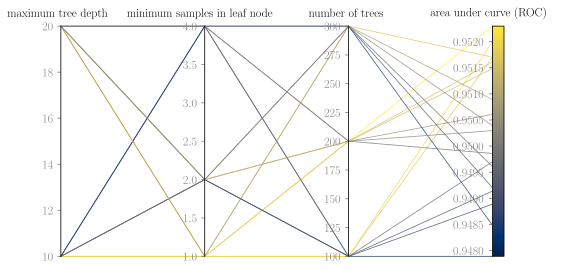

In [8]:
fig = plot_par_coordinates(results, labels=["maximum tree depth", "minimum samples in leaf node", "number of trees", "area under curve (ROC)"],
                           figsize=(8, 4), curves=False, linewidth=0.8, alpha=0.8, cmap=plt.get_cmap("cividis"))
fig.savefig("../outputs/figures/grid_search.png", dpi=300)

#### RandomizedSearchCV

In [9]:
# define the parameter distributions to sample from
param_dist = {
    'n_estimators': randint(100, 1000), # number of trees
    'max_depth': randint(1, 100, 20), # maximum depth for a given tree
    'min_samples_leaf': randint(1, 20) # minimum number of samples in a leaf node
}
# initialize the random forest classifier
rf_clf = RandomForestClassifier(random_state=42)
# perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_dist, n_iter=100, cv=5, scoring="f1", n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train);

In [10]:
results = get_results.sklearn(grid_search, "f1_score")
display(results.head())

,max_depth,min_samples_leaf,n_estimators,f1_score
0,10,1,100,0.951703
1,10,1,200,0.952297
2,10,1,300,0.951703
3,10,2,100,0.947889
4,10,2,200,0.950609


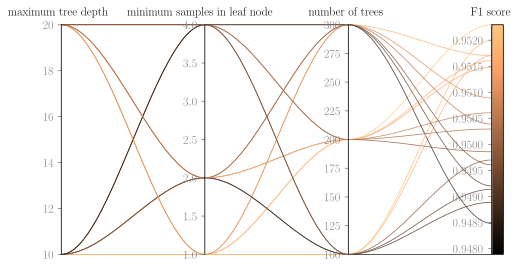

In [11]:
fig = plot_par_coordinates(results, labels=["maximum tree depth", "minimum samples in leaf node", "number of trees", "F1 score"],
                           figsize=(8, 4), curves=True, linewidth=0.8, alpha=0.8, cmap=plt.get_cmap("copper"))
fig.savefig("../outputs/figures/random_search.png", dpi=300)

## Optuna
[Optuna](https://optuna.org/) is powerful framework for hyperparameter tuning compatible with most modern frameworks for machine learning and deep learning. Below you can find an example of Bayesian optimization for the hyperparameters of a gradient boosted tree regressor using the popular [XGBoost](https://xgboost.readthedocs.io/en/stable/) library.

In [12]:
# load the diabetes dataset from sklearn
diabetes_data = load_diabetes()
# extract features and target variable
X = diabetes_data.data
y = diabetes_data.target
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# cast to xgboost DMatrix for better efficiency (there is also a scikit-learn-like API)
dm_train = xgb.DMatrix(X_train, label=y_train)

In [13]:
def objective(trial):
    """
    Objective function that takes in a given trial and returns a performance metric to minimize/maximize
    """
    # define the hyperparameters to be tuned
    params = {
        "objective": "reg:squarederror", # squared error loss
        "eval_metric": "rmse", # root mean squared error
        "device": "cuda:0", # GPU integration
        "subsample": 0.8, # fraction of features bootstrapped for a given tree
        "max_depth": trial.suggest_int("max_depth", 1, 12), # maximum tree depth
        "eta": trial.suggest_float("eta", 0.05, 0.5), # regularization
        "gamma": trial.suggest_float("gamma", 0.001, 0.01), # regularization
        "lambda": trial.suggest_float("lambda", 0.1, 5), # regularization
        "alpha": trial.suggest_float("alpha", 0.001, 0.01), # regularization
    }
    # set up cross-validation model
    xgb_cv = xgb.cv(params, dm_train, num_boost_round=2000, nfold=5, early_stopping_rounds=5, verbose_eval=False, as_pandas=True)
    mse = xgb_cv["test-rmse-mean"].min() # best mse encountered
    std = xgb_cv.loc[xgb_cv["test-rmse-mean"].idxmin(), "test-rmse-std"] # corresponding cv error
    # log how many estimators were used (after early stopping) and standard deviation
    trial.set_user_attr("n_estimators", len(xgb_cv))
    trial.set_user_attr("std", std)
    # print update
    print(f"Trial #{trial.number}. Root Mean Squared Error = {mse:.4f} +/- {std:.4f}")
    return mse

In [14]:
# set up optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

Trial #0. Root Mean Squared Error = 65.6408 +/- 2.8522
Trial #1. Root Mean Squared Error = 63.8812 +/- 5.2576
Trial #2. Root Mean Squared Error = 59.2559 +/- 3.8548
Trial #3. Root Mean Squared Error = 64.2643 +/- 3.2034
Trial #4. Root Mean Squared Error = 64.8460 +/- 2.9196
Trial #5. Root Mean Squared Error = 64.5630 +/- 3.3356
Trial #6. Root Mean Squared Error = 65.3355 +/- 5.1452
Trial #7. Root Mean Squared Error = 61.9160 +/- 5.1717
Trial #8. Root Mean Squared Error = 61.0869 +/- 5.1752
Trial #9. Root Mean Squared Error = 58.6701 +/- 3.8775
Trial #10. Root Mean Squared Error = 58.7126 +/- 3.6883
Trial #11. Root Mean Squared Error = 58.5353 +/- 3.4097
Trial #12. Root Mean Squared Error = 59.2704 +/- 4.1671
Trial #13. Root Mean Squared Error = 59.2558 +/- 4.0186
Trial #14. Root Mean Squared Error = 60.0274 +/- 3.4948
Trial #15. Root Mean Squared Error = 58.0054 +/- 3.3243
Trial #16. Root Mean Squared Error = 58.4294 +/- 3.9879
Trial #17. Root Mean Squared Error = 57.9078 +/- 3.3271
Tr

In [15]:
results = get_results.optuna(study, "mse", ["n_estimators", "std"])
display(results.head())

,max_depth,alpha,eta,gamma,lambda,mse
0,9,0.005817,0.395350,0.003635,1.421170,65.640787
1,7,0.004637,0.260459,0.002457,0.627436,63.881199
2,1,0.004510,0.406984,0.006516,3.144145,59.255920
3,7,0.001942,0.352228,0.009057,1.488303,64.264315
4,7,0.001783,0.386219,0.003841,1.735642,64.845989


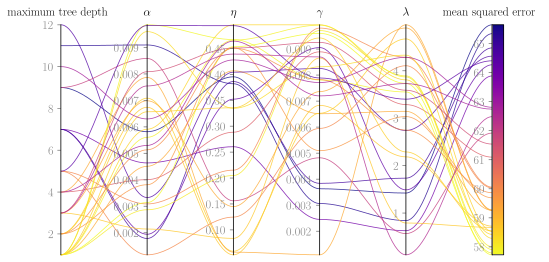

In [16]:
fig = plot_par_coordinates(results, labels=["maximum tree depth", "$\\alpha$", "$\eta$", "$\gamma$", "$\lambda$", "mean squared error"],
                           figsize=(8, 4), curves=True, linewidth=0.8, alpha=0.8, cmap=plt.get_cmap("plasma_r"))
fig.savefig("../outputs/figures/optuna.png", dpi=300)

## mtcars

Parallel coordinates plots can also be used to quickly visualize dependencies between features in small datasets. While this package has not been developed with this use in mind, its functions can quickly be readapted for the purpose. As an example, we consider the famous [mtcars](https://web.mit.edu/r/current/lib/R/library/datasets/html/mtcars.html) dataset.

In [17]:
import pandas as pd

# load the dataset
mtcars = pd.read_csv("../data/mtcars.csv")
display(mtcars.head())

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


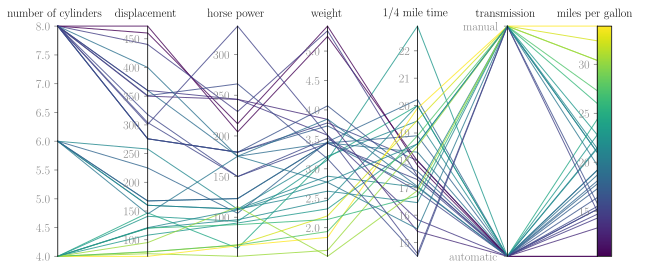

In [18]:
# let's consider only a few features for simplicity
mtcars = mtcars[["cyl", "disp", "hp", "wt", "qsec", "am", "mpg"]]
mtcars["am"] = mtcars["am"].apply(lambda n: "automatic" if n == 0 else "manual")

fig = plot_par_coordinates(mtcars, labels=["number of cylinders", "displacement", "horse power", "weight", "1/4 mile time", "transmission", "miles per gallon"],
                           figsize=(10, 4), curves=False, linewidth=1., alpha=0.8, colorbar=True, cmap=plt.get_cmap("viridis"))
fig.savefig("../outputs/figures/mtcars.png", dpi=300)

We can clearly see that heavier, faster and more powerful cars tend to be less fuel-efficient. In addition, we might get the impression that cars with manual transmission are more fuel-efficient, but upon closer inspection we notice that this is because mostly light, less powerful cars have manual transmission.